In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:45959")
client

<Client: 'tcp://127.0.0.1:45959' processes=8 threads=40, memory=157.39 GiB>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import os.path as op
import os
import gsw
import xrft
import xwavelet
from scipy.interpolate import interp2d, bisplrep, bisplev, griddata
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
from fastjmd95 import rho as densjmd95
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/tank/chaocean/'
savedir = '/tank/topog/tuchida/TWA/'
tdgs = '/tank/tdgs/tuchida/TWA'

In [4]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
# Cp = 3.994e3
Cp = 3989.244953
# years = np.arange(2008,2013,dtype=int)
ySstart = -15
yNstart = 15
yend = 50
dnf = 2160
nfile = 73

In [5]:
years = np.arange(1967,1968,dtype=int)
ntimes = np.arange(1421280,1576800+dnf,dnf).reshape(len(years),nfile)
dd = 0  # 
yystart = 0
ntimes[yystart,:]

array([1421280, 1423440, 1425600, 1427760, 1429920, 1432080, 1434240,
       1436400, 1438560, 1440720, 1442880, 1445040, 1447200, 1449360,
       1451520, 1453680, 1455840, 1458000, 1460160, 1462320, 1464480,
       1466640, 1468800, 1470960, 1473120, 1475280, 1477440, 1479600,
       1481760, 1483920, 1486080, 1488240, 1490400, 1492560, 1494720,
       1496880, 1499040, 1501200, 1503360, 1505520, 1507680, 1509840,
       1512000, 1514160, 1516320, 1518480, 1520640, 1522800, 1524960,
       1527120, 1529280, 1531440, 1533600, 1535760, 1537920, 1540080,
       1542240, 1544400, 1546560, 1548720, 1550880, 1553040, 1555200,
       1557360, 1559520, 1561680, 1563840, 1566000, 1568160, 1570320,
       1572480, 1574640, 1576800])

In [6]:
xs = [295,318,
      297.5,316,
      300,315
     ]
ys = [37,43,
      30.5,30,
      24,22
     ]

dCs = 1e-5
Cs = xr.open_zarr(op.join(tdgs,'5Dave/Max_sound-speed/run1967/')).Cs

xo = 50e3
s = xr.DataArray(np.arange(.5,10.5,.5), dims=['scale'], 
                 coords={'scale':np.arange(.5,10.5,.5)}
                )

/tmp/ipykernel_39442/3829648471.py:11: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  Cs = xr.open_zarr(op.join(tdgs,'5Dave/Max_sound-speed/run1967/')).Cs


## $$\Pi(k) = -\frac{1}{C_\Psi}\int_{\kappa>k} \mathcal{R}\left[\tilde{q'} \widetilde{({\bf u}\cdot\nabla q)'}^*\right] x_0^2 \kappa\, d\kappa$$

# Wavelet
## Native grid

<xarray.DataArray (nmemb: 48, Z: 2, YC: 120, XC: 116)>
dask.array<getitem, shape=(48, 2, 120, 116), dtype=float64, chunksize=(1, 1, 120, 116), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58 59
  * Z        (Z) >f4 -227.6 -1.137e+03
  * YC       (YC) >f4 32.0 32.08 32.17 32.25 32.33 ... 41.67 41.75 41.83 41.92
  * XC       (XC) >f4 290.1 290.1 290.2 290.3 290.4 ... 299.7 299.8 299.9 300.0
<xarray.DataArray (nmemb: 48, Z: 2, angle: 18, scale: 20)>
array([[[[ 1.24100254e-28, -2.02502631e-27, -2.51373536e-27, ...,
          -1.12402240e-25, -1.15858526e-25, -1.19107726e-25],
         [ 4.69195226e-30, -6.18719055e-28, -3.19939283e-27, ...,
           1.72054556e-25,  2.03692103e-25,  2.25793049e-25],
         [ 2.87422741e-31, -3.99126883e-29, -6.00083472e-28, ...,
           2.62333013e-25,  3.08644612e-25,  3.42152164e-25],
         ...,
         [ 2.67835523e-29, -2.62567151e-27, -2.87999424e-26, ...,
          -1.6686

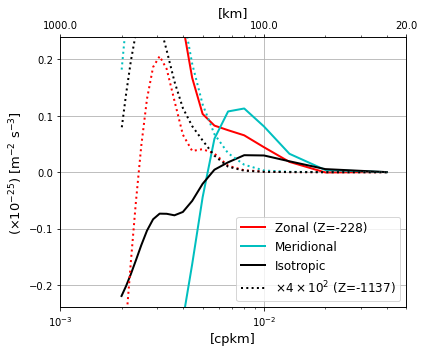

<xarray.DataArray (nmemb: 48, Z: 2, YC: 120, XC: 116)>
dask.array<getitem, shape=(48, 2, 120, 116), dtype=float64, chunksize=(1, 1, 120, 116), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58 59
  * Z        (Z) >f4 -227.6 -1.137e+03
  * YC       (YC) >f4 38.0 38.08 38.17 38.25 38.33 ... 47.67 47.75 47.83 47.92
  * XC       (XC) >f4 313.0 313.1 313.2 313.3 313.4 ... 322.7 322.8 322.8 322.9
<xarray.DataArray (nmemb: 48, Z: 2, angle: 18, scale: 20)>
array([[[[ 7.63683792e-32,  1.07353687e-29,  7.00835196e-29, ...,
           1.01985389e-26,  9.59518399e-27,  8.94043172e-27],
         [ 3.73969016e-32, -2.53389910e-30, -3.82097104e-30, ...,
          -5.72253838e-27, -6.31661626e-27, -6.93260262e-27],
         [-2.00627888e-32,  1.33160659e-30, -1.02869346e-28, ...,
          -1.86718227e-26, -1.90371804e-26, -1.94654771e-26],
         ...,
         [ 2.47369483e-31,  4.04134651e-28,  3.22352666e-27, ...,
           1.2784

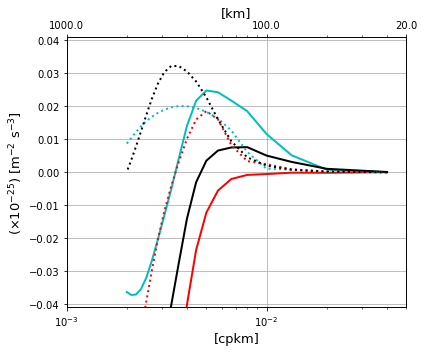

<xarray.DataArray (nmemb: 48, Z: 2, YC: 120, XC: 116)>
dask.array<getitem, shape=(48, 2, 120, 116), dtype=float64, chunksize=(1, 1, 120, 116), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58 59
  * Z        (Z) >f4 -227.6 -1.137e+03
  * YC       (YC) >f4 25.5 25.58 25.67 25.75 25.83 ... 35.17 35.25 35.33 35.42
  * XC       (XC) >f4 292.6 292.6 292.7 292.8 292.9 ... 302.2 302.3 302.4 302.4
<xarray.DataArray (nmemb: 48, Z: 2, angle: 18, scale: 20)>
array([[[[-1.96900453e-33,  1.19343298e-29,  5.12033105e-29, ...,
          -3.21599825e-26, -3.53294241e-26, -3.77782569e-26],
         [-6.20692404e-33,  2.21617464e-29,  7.43830346e-29, ...,
          -3.70349134e-26, -4.04854054e-26, -4.28637135e-26],
         [ 6.75603572e-33,  1.04222493e-29,  9.75552425e-29, ...,
          -3.62347277e-26, -4.17798208e-26, -4.65193357e-26],
         ...,
         [ 2.08116551e-32,  6.38527424e-29,  2.34723242e-28, ...,
           1.0310

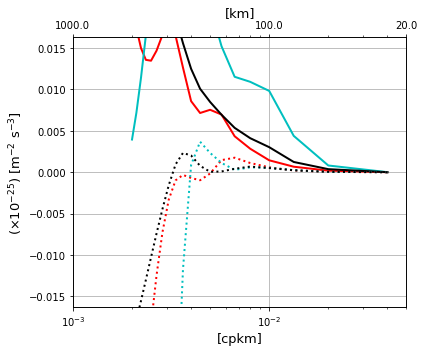

<xarray.DataArray (nmemb: 48, Z: 2, YC: 120, XC: 116)>
dask.array<getitem, shape=(48, 2, 120, 116), dtype=float64, chunksize=(1, 1, 120, 116), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58 59
  * Z        (Z) >f4 -227.6 -1.137e+03
  * YC       (YC) >f4 25.0 25.08 25.17 25.25 25.33 ... 34.67 34.75 34.83 34.92
  * XC       (XC) >f4 311.1 311.1 311.2 311.3 311.4 ... 320.7 320.8 320.9 321.0
<xarray.DataArray (nmemb: 48, Z: 2, angle: 18, scale: 20)>
array([[[[ 1.19141392e-33,  2.23944343e-30, -2.57872247e-30, ...,
           1.15205890e-27,  1.25673665e-27,  1.29517262e-27],
         [ 1.15846758e-34,  9.19716153e-31,  9.79758306e-30, ...,
           3.84700097e-28,  4.68076465e-28,  5.42126820e-28],
         [-1.44605873e-34,  1.51359320e-30,  2.18148319e-29, ...,
          -2.25898732e-28, -1.53676570e-28, -2.00866873e-29],
         ...,
         [ 6.35180063e-33,  1.82344916e-30, -6.68359351e-30, ...,
          -9.4117

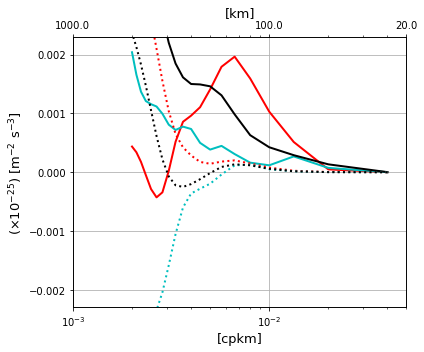

<xarray.DataArray (nmemb: 48, Z: 2, YC: 120, XC: 116)>
dask.array<getitem, shape=(48, 2, 120, 116), dtype=float64, chunksize=(1, 1, 120, 116), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58 59
  * Z        (Z) >f4 -227.6 -1.137e+03
  * YC       (YC) >f4 19.0 19.08 19.17 19.25 19.33 ... 28.67 28.75 28.83 28.92
  * XC       (XC) >f4 295.0 295.1 295.2 295.3 295.4 ... 304.7 304.8 304.9 304.9
<xarray.DataArray (nmemb: 48, Z: 2, angle: 18, scale: 20)>
array([[[[-4.44460119e-35, -1.63618490e-32,  3.81130809e-29, ...,
          -6.01921666e-27, -6.75152778e-27, -7.32692811e-27],
         [-1.51439366e-35,  5.48521190e-32, -1.78253776e-31, ...,
           1.88206209e-27,  2.10119466e-27,  2.27721850e-27],
         [-1.10963502e-34,  6.07991107e-32,  6.55012075e-31, ...,
           4.46759054e-27,  4.62021924e-27,  4.69622952e-27],
         ...,
         [ 7.59995115e-33,  4.55350694e-29,  3.62846410e-28, ...,
           4.0014

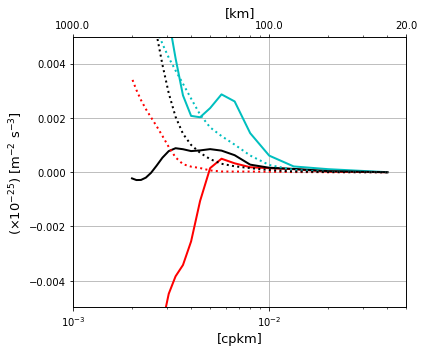

<xarray.DataArray (nmemb: 48, Z: 2, YC: 120, XC: 116)>
dask.array<getitem, shape=(48, 2, 120, 116), dtype=float64, chunksize=(1, 1, 120, 116), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58 59
  * Z        (Z) >f4 -227.6 -1.137e+03
  * YC       (YC) >f4 17.0 17.08 17.17 17.25 17.33 ... 26.67 26.75 26.83 26.92
  * XC       (XC) >f4 310.0 310.1 310.2 310.3 310.4 ... 319.7 319.7 319.8 319.9
<xarray.DataArray (nmemb: 48, Z: 2, angle: 18, scale: 20)>
array([[[[ 2.39493377e-33,  1.50091216e-29,  7.94671794e-29, ...,
          -2.09897767e-27, -2.03982877e-27, -1.97525370e-27],
         [-3.42987265e-33,  2.51836318e-29,  6.63534587e-29, ...,
          -1.25987673e-27, -1.18164937e-27, -1.09897976e-27],
         [-3.42683701e-33,  1.58145990e-29,  1.90459619e-29, ...,
          -1.90063016e-27, -1.88672406e-27, -1.85103888e-27],
         ...,
         [ 2.35724961e-34,  5.49977336e-31,  2.99759679e-29, ...,
           2.1516

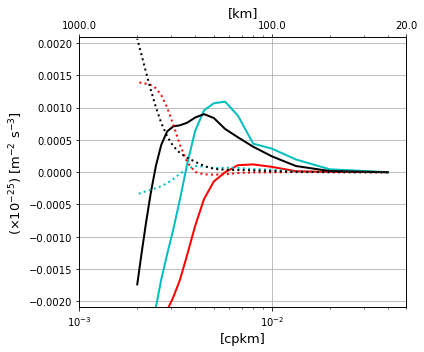

In [22]:
nmembs = np.concatenate((np.arange(24),np.arange(36,60)))
xchunk = 100
ychunk = 100

yy = yystart

for reg in range(len(xs)):
    for year in years[yystart:]:
        if year == years[yystart]:
            mtimes = ntimes[yy,:dd+1]
        else:
            mtimes = ntimes[yy]
        for itime in mtimes:
            
            dsgrd = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                            % (0,years[0])), 
                                    grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                    iters=ntimes[0,0],
                                    prefix=['diag_ocnSnap'], delta_t=2e2,
                                   ).sel(YC=slice(ys[reg]-5-2/12,ys[reg]+5+2/12),
                                         YG=slice(ys[reg]-5-2/12,ys[reg]+5+2/12),
                                         XC=slice(xs[reg]-5-2/12,xs[reg]+5+2/12),
                                         XG=slice(xs[reg]-5-2/12,xs[reg]+5+2/12)
                                        )
            
            dsq = xr.open_zarr(op.join(tdgs,
                                       '5Dave/run%4d/EddyErtelPV/%2dmembers/15N-50N_%010d.zarr'
                                       % (year,len(nmembs),itime))
                              ).sel(YC=slice(ys[reg]-5-2/12,ys[reg]+5+2/12),
                                    XC=slice(xs[reg]-5-2/12,xs[reg]+5+2/12)
                                   ).chunk({'Z':1})
            
            for nmemb in nmembs:
                if nmemb == 0:
                    ds = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                                 % (nmemb,year)), 
                                         grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                         prefix=['diag_ocnTave'], delta_t=2e2,
                                         iters=itime, 
                                        ).sel(YC=slice(ys[reg]-5-2/12,ys[reg]+5+2/12),
                                              YG=slice(ys[reg]-5-2/12,ys[reg]+5+2/12),
                                              XC=slice(xs[reg]-5-2/12,xs[reg]+5+2/12),
                                              XG=slice(xs[reg]-5-2/12,xs[reg]+5+2/12)
                                             ).isel(time=0
                                                   ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1})
                else:
                    ds = xr.concat([ds, 
                                    open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                                            % (nmemb,year)), 
                                                    grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                                    prefix=['diag_ocnTave'], delta_t=2e2,
                                                    iters=itime, 
                                                   ).sel(YC=slice(ys[reg]-5-2/12,ys[reg]+5+2/12),
                                                         YG=slice(ys[reg]-5-2/12,ys[reg]+5+2/12),
                                                         XC=slice(xs[reg]-5-2/12,xs[reg]+5+2/12),
                                                         XG=slice(xs[reg]-5-2/12,xs[reg]+5+2/12)
                                                        ).isel(time=0
                                                              ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1})
                                   ], dim='nmemb')

            # ds = ds.chunk({'nmemb':6})
            ds.coords['nmemb'] = ('nmemb',nmembs)

        
            grid = Grid(ds, periodic=[])

            v = ds.VVEL.where(ds.maskS!=0.)
            u = ds.UVEL.where(ds.maskW!=0.)
            theta = ds.THETA.where(ds.maskC!=0.)
            salt = ds.SALT.where(ds.maskC!=0.)

            rho_til = grid.interp(rhoConst*(1. - grav*(-grid.cumsum((Cs+dCs)**-2*ds.drF, 'Z',
                                                                    boundary='extend')
                                                      )),
                                  'Z', boundary='extend'
                                 )
            pres = rhoConst*grav*(-ds.Z) * 1e-4
            rho = xr.apply_ufunc(densjmd95, salt, theta, 
                                 pres, 
                                 dask='parallelized', output_dtypes=[float,]
                                )
            b = -(rho - rho_til) / rhoConst

            zeta = grid.interp(grid.interp((grid.diff(v*ds.dyC,'X',boundary='extend')
                                            - grid.diff(u*ds.dxC,'Y',boundary='extend')
                                           ) / ds.rAz,'X',boundary='extend'
                                          ),'Y',boundary='extend'
                              )
            b_z = grid.interp(-grid.diff(b,'Z',boundary='extend') 
                              / ds.drC.data[np.newaxis,:-1,np.newaxis,np.newaxis],
                              'Z',boundary='extend')
            b_y = grid.interp(grid.diff(b,'Y',boundary='extend') / ds.dyC,'Y',boundary='extend')
            b_x = grid.interp(grid.diff(b,'X',boundary='extend') / ds.dxC,'X',boundary='extend')
            v_z = grid.interp(-grid.diff(v,'Z',boundary='extend') 
                              / ds.drC.data[np.newaxis,:-1,np.newaxis,np.newaxis],
                              'Z',boundary='extend')
            u_z = grid.interp(-grid.diff(u,'Z',boundary='extend') 
                              / ds.drC.data[np.newaxis,:-1,np.newaxis,np.newaxis],
                              'Z',boundary='extend')
            f = xr.apply_ufunc(gsw.f, ds.YC)

            PVv = ((zeta+f)*b_z).reset_coords(drop=True)
            PVh = (-grid.interp(v_z,'Y',boundary='extend')*b_x 
                   + grid.interp(u_z,'X',boundary='extend')*b_y
                  ).reset_coords(drop=True)
            PV = PVh + PVv

            Aq = ((grid.interp(u * grid.diff(PV*grid.interp(ds.dyG,'X',boundary='extend'),'X',boundary='extend'),
                               'X',boundary='extend').isel(Z=[14,24])
                   + grid.interp(v * grid.diff(PV*grid.interp(ds.dxG,'Y',boundary='extend'),'Y',boundary='extend'),
                                 'Y',boundary='extend').isel(Z=[14,24])
                  ) / ds.rA).isel(YC=slice(2,-2),XC=slice(2,-2)).reset_coords(drop=True)
            print(Aq)
            
            Aqp = Aq - Aq.mean('nmemb',skipna=True)
#             Aqp.isel(nmemb=0,Z=0).plot()
#             plt.show()

            dx = grid.interp(ds.dxC,'X',boundary='extend').mean(skipna=True)
            dy = grid.interp(ds.dyC,'Y',boundary='extend').mean(skipna=True)
            N = Aqp.shape
            Aqp = xr.DataArray(Aqp.data, dims=Aqp.dims, 
                               coords={'nmemb':Aqp.nmemb,'Z':Aqp.Z,
                                       'YC':np.arange(0,N[-2]*dy,dy),
                                       'XC':np.arange(0,N[-1]*dx,dx)}
                              )

            
            PVp = (dsq.pEPVh + dsq.pEPVv).isel(YC=slice(2,-2),XC=slice(2,-2))
#             PVp.isel(nmemb=0,Z=0).plot()
#             plt.show()
            PVp = xr.DataArray(PVp.data, dims=PVp.dims, 
                               coords={'nmemb':PVp.nmemb,'Z':PVp.Z,
                                       'YC':np.arange(0,N[-2]*dy,dy),
                                       'XC':np.arange(0,N[-1]*dx,dx)}
                              )
            ntheta = 36
            iso_csQAq = xwavelet.wvlt_cross_spectrum(
                    PVp, Aqp, s, dim=["YC", "XC"], xo=xo, ntheta=ntheta
            )
            
            
#             eta = -(iso_csQAq*np.diff(iso_csQAq.scale**-1)[0])[::-1].cumsum('scale')[::-1]
            eta = (iso_csQAq*np.diff(iso_csQAq.scale**-1)[0]).cumsum('scale').compute()
            print(eta)

            fig, ax = plt.subplots(figsize=(6,5))
            fig.set_tight_layout(True)
#             ax2 = ax.twinx()
            ax3 = ax.twiny()
            ax.plot((eta.scale)**-1*1e3, eta.isel(angle=0,Z=0).mean(['nmemb'])*1e25,
                    'r', lw=2, label=r"Zonal (Z=-228)")
            ax.plot((eta.scale)**-1*1e3, eta.isel(angle=ntheta//2//2-1,Z=0).mean(['nmemb'])*1e25,
                    'c', lw=2, label=r"Meridional")
            ax.plot((eta.scale)**-1*1e3, eta.isel(Z=0).mean(['nmemb','angle'])*1e25,
                    'k', lw=2, label=r"Isotropic")
            ax.plot((eta.scale)**-1*1e3, eta.isel(angle=0,Z=1).mean(['nmemb'])*4e27,
                     'r:', lw=2)
            ax.plot((eta.scale)**-1*1e3, eta.isel(angle=ntheta//2//2-1,Z=1).mean(['nmemb'])*4e27,
                     'c:', lw=2)
            ax.plot((eta.scale)**-1*1e3, eta.isel(Z=1).mean(['nmemb','angle'])*4e27,
                     'k:', lw=2, label=r"$\times 4\times10^{2}$ (Z=-1137)")
#             ax.plot((iso_csUAq.scale)**-1*1e3, ((iso_psPV.scale/xo)**-1)**-1*1e-19, 
#                      ls='--', c='grey', alpha=.8, label=r"$k^{-1}$")
#             ax.plot((iso_psPV.scale)**-1*1e3, ((iso_psPV.scale/xo)**-2)**-2*6e-22, 
#                      ls='-.', c='grey', alpha=.8, label=r"$k^{-2}$")
#             ax2.plot((iso_csUAq.scale)**-1*1e3, xr.ones_like(iso_psPV.scale)*1e-19, 
#                      ls='--', c='grey', alpha=0)
            ax.set_xscale('log')
#             ax.set_yscale('log')
            ax3.set_xscale('log')
#             ax2.set_yscale('log')
            ax.set_xlim([1e-3,5e-2])
            ax3.set_xlim([1e-3,5e-2])
            ax3.set_xticks([1e-3,1e-2,5e-2])
            ax3.set_xticklabels([1e3,1e2,2e1])
            Meta = np.fmax(np.fmax(np.abs(eta.isel(Z=0).mean(['nmemb','angle'])).max(skipna=True).values*1e25,
                                   np.abs(eta.isel(Z=0,angle=0).mean(['nmemb'])).max(skipna=True).values*1e25),
                           np.abs(eta.isel(angle=ntheta//2//2-1,Z=0).mean(['nmemb'])).max(skipna=True).values*1e25
                          )
            ax.set_ylim([-.5*Meta, .5*Meta])
            ax.set_xlabel(r"[cpkm]", fontsize=13)
            ax3.set_xlabel(r"[km]", fontsize=13)
            ax.set_ylabel(r"($\times 10^{-25}$) [m$^{-2}$ s$^{-3}$]", fontsize=13)
#             ax2.set_ylabel(r"(Z=-1137) [m$^{-2}$ s$^{-3}$]", fontsize=13)
            ax.grid(True)
#             align_yaxis(ax, 0, ax2, 0)
            if reg == 0:
                ax.legend(loc='lower right', fontsize=12)
#                 ax2.legend(loc='upper right', fontsize=12)
            plt.savefig(op.join('/tank/topog/tuchida/Wavelet-spectrum/Figs/Ens-specflux_Region%02d.pdf' % reg))
            plt.show()

# Fourier

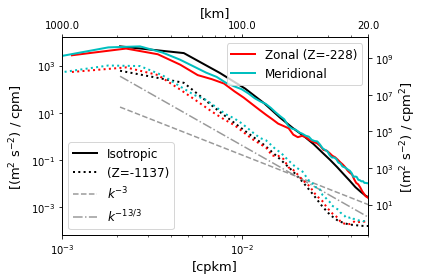

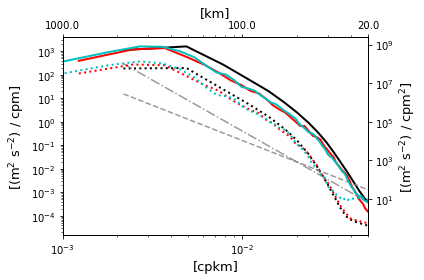

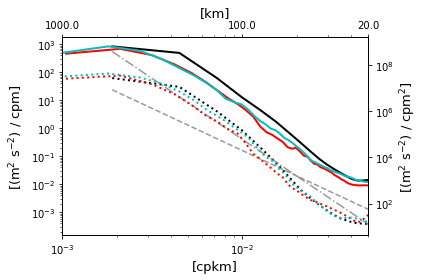

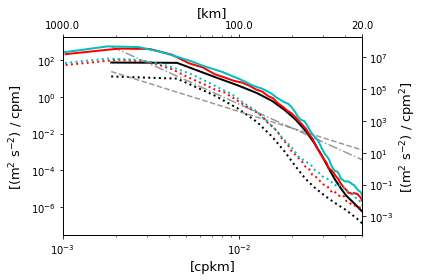

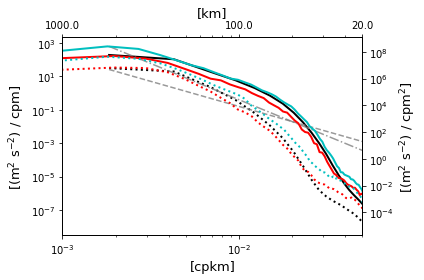

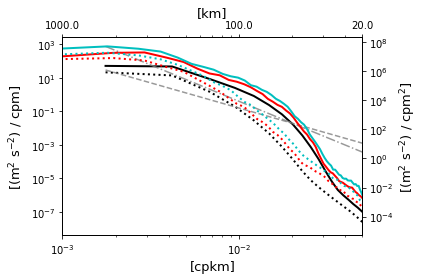

In [12]:
nmembs = np.concatenate((np.arange(24),np.arange(36,60)))
xchunk = 100
ychunk = 100

yy = yystart

for reg in range(len(xs)):
    for year in years[yystart:]:
        if year == years[yystart]:
            mtimes = ntimes[yy,:dd+1]
        else:
            mtimes = ntimes[yy]
        for itime in mtimes:

            dsb = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Ensemble-mean/%2dmembers/15N-50N_%010d.zarr'
                                       % (year,len(nmembs),itime))
                              ).isel(time=0
                                    ).sel(YC=slice(ys[reg]-5,ys[reg]+5),
                                          YG=slice(ys[reg]-5,ys[reg]+5),
                                          XC=slice(xs[reg]-5,xs[reg]+5),
                                          XG=slice(xs[reg]-5,xs[reg]+5)
                                         ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1})

            for nmemb in nmembs:
                if nmemb == 0:
                    ds = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                                 % (nmemb,year)), 
                                         grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                         prefix=['diag_ocnTave'], delta_t=2e2,
                                         iters=itime, 
                                        ).sel(YC=slice(ys[reg]-5,ys[reg]+5),
                                              YG=slice(ys[reg]-5,ys[reg]+5),
                                              XC=slice(xs[reg]-5,xs[reg]+5),
                                              XG=slice(xs[reg]-5,xs[reg]+5)
                                             ).isel(time=0
                                                   ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1})
                else:
                    ds = xr.concat([ds, 
                                    open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                                            % (nmemb,year)), 
                                                    grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                                    prefix=['diag_ocnTave'], delta_t=2e2,
                                                    iters=itime, 
                                                   ).sel(YC=slice(ys[reg]-5,ys[reg]+5),
                                                         YG=slice(ys[reg]-5,ys[reg]+5),
                                                         XC=slice(xs[reg]-5,xs[reg]+5),
                                                         XG=slice(xs[reg]-5,xs[reg]+5)
                                                        ).isel(time=0
                                                              ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1})
                                   ], dim='nmemb')

            # ds = ds.chunk({'nmemb':6})
        ds.coords['nmemb'] = ('nmemb',nmembs)
        
        grid = Grid(ds, periodic=[])

        up = grid.interp((ds.UVEL - dsb.UVEL).where(ds.maskW!=0.),
                         'X',boundary='extend').isel(Z=[14,24]).chunk({'YC':-1,'XC':-1}).interpolate_na(dim='XC'
                                                               ).interpolate_na(dim='YC'
                                                                               ).fillna(0.)
        vp = grid.interp((ds.VVEL - dsb.VVEL).where(ds.maskS!=0.),
                         'Y',boundary='extend').isel(Z=[14,24]).chunk({'YC':-1,'XC':-1}).interpolate_na(dim='YC'
                                                               ).interpolate_na(dim='XC'
                                                                               ).fillna(0.)
        
        dx = grid.interp(ds.dxC,'X',boundary='extend').mean(skipna=True)
        dy = grid.interp(ds.dyC,'Y',boundary='extend').mean(skipna=True)
        N = up.shape
        up = xr.DataArray(up.data, dims=up.dims, 
                          coords={'nmemb':up.nmemb,'Z':up.Z,
                                  'YC':np.arange(0,N[-2]*dy,dy),
                                  'XC':np.arange(0,N[-1]*dx,dx)}
                         )
        vp = xr.DataArray(vp.data, dims=vp.dims, 
                          coords={'nmemb':vp.nmemb,'Z':vp.Z,
                                  'YC':np.arange(0,N[-2]*dy,dy),
                                  'XC':np.arange(0,N[-1]*dx,dx)}
                         )
        
        psU = xrft.power_spectrum(
                up, dim=["YC", "XC"], window='hann', 
                window_correction=True, true_amplitude=True
        )
        psV = xrft.power_spectrum(
                vp, dim=["YC", "XC"], window='hann', 
                window_correction=True, true_amplitude=True
        )
        
        iso_psU = xrft.isotropic_power_spectrum(
                up, dim=["YC", "XC"], window='hann', 
                window_correction=True, true_amplitude=True, truncate=True
        )
        iso_psV = xrft.isotropic_power_spectrum(
                vp, dim=["YC", "XC"], window='hann', 
                window_correction=True, true_amplitude=True, truncate=True
        )
        
        fig, ax = plt.subplots()
        fig.set_tight_layout(True)
        ax2 = ax.twinx()
        ax3 = ax.twiny()
        ax2.plot(psU.freq_XC[int(N[-1]/2)+1:]*1e3, 
                .5*(psU + psV).isel(Z=0,freq_XC=slice(int(N[-1]/2)+1,None)).sel(freq_YC=0).mean(['nmemb']),
                'r', lw=2, label=r"Zonal (Z=-228)")
        ax2.plot(psU.freq_YC[int(N[-2]/2)+1:]*1e3, 
                .5*(psU + psV).isel(Z=0,freq_YC=slice(int(N[-2]/2)+1,None)).sel(freq_XC=0).mean(['nmemb']),
                'c', lw=2, label=r"Meridional")
        ax.plot(iso_psU.freq_r[:]*1e3, .5*(iso_psU + iso_psV).isel(Z=0,freq_r=slice(None,None)).mean(['nmemb']),
                'k', lw=2, label=r"Isotropic")
        ax2.plot(psU.freq_XC[int(N[-1]/2)+1:]*1e3, 
                .5*(psU + psV).isel(Z=1,freq_XC=slice(int(N[-1]/2)+1,None)).sel(freq_YC=0).mean(['nmemb']),
                'r:', lw=2)
        ax2.plot(psU.freq_YC[int(N[-2]/2)+1:]*1e3, 
                .5*(psU + psV).isel(Z=1,freq_YC=slice(int(N[-2]/2)+1,None)).sel(freq_XC=0).mean(['nmemb']),
                'c:', lw=2)
        ax.plot(iso_psU.freq_r[:]*1e3, .5*(iso_psU + iso_psV).isel(Z=1,freq_r=slice(None,None)).mean(['nmemb']),
                'k:', lw=2, label=r"(Z=-1137)")
        ax.plot(iso_psU.freq_r*1e3, (iso_psU.freq_r*xo)**-3*2e-2, 
                 ls='--', c='grey', alpha=.8, label=r"$k^{-3}$")
        ax.plot(iso_psU.freq_r*1e3, (iso_psU.freq_r*xo)**-(13/3)*2e-2, 
                 ls='-.', c='grey', alpha=.8, label=r"$k^{-13/3}$")
        ax3.plot(iso_psU.freq_r*1e3, xr.ones_like(iso_psU.freq_r)*1e1, 
                 ls='--', c='grey', alpha=0)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax2.set_xscale('log')
        ax2.set_yscale('log')
        ax3.set_xscale('log')
        ax3.set_yscale('log')
        ax.set_xlim([1e-3,5e-2])
        ax3.set_xlim([1e-3,5e-2])
        ax3.set_xticks([1e-3,1e-2,5e-2])
        ax3.set_xticklabels([1e3,1e2,2e1])
        ax.set_xlabel(r"[cpkm]", fontsize=13)
        ax3.set_xlabel(r"[km]", fontsize=13)
        ax.set_ylabel(r"[(m$^2$ s$^{-2}$) / cpm]", fontsize=13)
        ax2.set_ylabel(r"[(m$^2$ s$^{-2}$) / cpm$^2$]", fontsize=13)
        if reg == 0:
            ax.legend(loc='lower left', fontsize=12)
            ax2.legend(loc='upper right', fontsize=12)
        plt.savefig(op.join('/tank/topog/tuchida/Wavelet-spectrum/Figs/KE-Fourierspec_Region%02d.pdf' % reg))
        plt.show()